<a href="https://colab.research.google.com/github/SP-TechForest/Python-creations/blob/main/Wine_Quality_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing all the necessary 
import pandas as pd
import numpy as np 
import plotly.express as px 
import seaborn as sns 
import matplotlib.pyplot as plt 
from pandas.core.common import flatten
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score

In [ ]:
#Load data-set
data = pd.read_csv('winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
#Print the number of columns and rows 
f"Data-set has {data.shape[0]} rows and {data.shape[1]} columns"

'Data-set has 1599 rows and 12 columns'

#Data Preparation 

##1. Find Null Values and Clean Dataset

In [ ]:
# Get Columns With Null Values 
Null_values = data.columns[data.isna().any()]
Null_values

Index([], dtype='object')

Data-set has No Null Values. 

##2. Find Outliers and Remove Outliers 

In [ ]:
# This Function Remove Outlier Using Standard Deviation Technique, This Returns Index Position of Outliers and Total Number of Outlier in Each Row. 
def remove_outlier_std(num_data):
  outlier_list = []
  outlier_index = []
  for i in num_data.columns:
    final_list = []
    sd = np.std(num_data[i].values)
    mean = np.mean(num_data[i].values)
    final_list = [x for x in range(num_data.shape[0]) if num_data[i][x]< mean - 3*sd]
    final_list = [x for x in range(num_data.shape[0]) if num_data[i][x]> mean + 3*sd]
    outlier_index.append(final_list)
    outlier_list.append(len(final_list))
  return outlier_index, outlier_list

In [ ]:
outlier_index, Outliers_ = remove_outlier_std(data) #Call The Function 
outlier_index = list(flatten(outlier_index)) #Flatten the shape of list, remove nested list 
outlier_index = list(dict.fromkeys(outlier_index)) #Remove Duplicate Values in List 
outlier_index.sort() # Sort the List 
print("Outliers based on standard deviation") #Prine Outliers
for i in range(len(data.columns)):
  print(f"{data.columns[i]} column has : {Outliers_[i]} outliers")

Outliers based on standard deviation
fixed acidity column has : 12 outliers
volatile acidity column has : 10 outliers
citric acid column has : 1 outliers
residual sugar column has : 30 outliers
chlorides column has : 31 outliers
free sulfur dioxide column has : 22 outliers
total sulfur dioxide column has : 15 outliers
density column has : 11 outliers
pH column has : 7 outliers
sulphates column has : 27 outliers
alcohol column has : 8 outliers
quality column has : 0 outliers


In [ ]:
cl_data = data.drop(outlier_index, axis=0) # Drop the outliers from Data-set

In [ ]:
#Data after cleaning and removing the outliers 
cl_data.shape # Remove 136 Rows

(1463, 12)

##3. Feature Selection 

###Correlation Technique

In [ ]:
data_corr = cl_data.corr() # Make Correlation Dataset

In [ ]:
px.imshow(data.corr(), title = 'Correlation Chart of Columns') #Plot correlation chart 

In [ ]:
data_corr['quality']

fixed acidity           0.132310
volatile acidity       -0.365155
citric acid             0.238434
residual sugar          0.053346
chlorides              -0.128296
free sulfur dioxide    -0.056245
total sulfur dioxide   -0.214660
density                -0.184672
pH                     -0.086507
sulphates               0.372029
alcohol                 0.497784
quality                 1.000000
Name: quality, dtype: float64

On the bases of correlation technique, we should remove three columns,<br>
1. residual sugar<br>
2. free sulfur dioxide<br>
3. pH

###Mutual Information Technique

In [ ]:
#Divide datset in to feature(x) and target(y)
x = cl_data.drop(columns = ['quality'])
y = cl_data.quality
importance = mutual_info_classif(x,y) # Apply mutual information classification on x and y  
px.bar(x = x.columns, y = importance, labels={
    'x': 'Columns',
    'y': 'Importance'
},
title = 'Mutual Information of various featurs',
color_discrete_sequence=px.colors.qualitative.Set2) #plot Bar Plot of information gain of each columns

In [ ]:
importance_col = [x.columns[i] for i in range(len(x.columns)) if importance[i]>0.04] #thrasold value is 0.04(based on my analysis)
importance_col

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'total sulfur dioxide',
 'density',
 'sulphates',
 'alcohol']

On the bases of Mutual Information Technique, we should remove four columns,<br>
1. residual sugar<br>
2. free sulfur dioxide<br>
3. pH
4. fixed acidity 

###Random Forest Importance

In [ ]:
rf_clf = RandomForestClassifier(criterion='entropy',n_estimators=20) #Create object RFC Model 
rfe_selector = RFE(estimator=rf_clf, n_features_to_select=6, step=10, verbose=5) #ste perams for RFE 
rfe_selector.fit(x, y) # Fit model on X and Y

Fitting estimator with 11 features.


RFE(estimator=RandomForestClassifier(criterion='entropy', n_estimators=20),
    n_features_to_select=6, step=10, verbose=5)

In [ ]:
rfe_columns = rfe_selector.get_support() # Get best columns based on trained model, returns boolian values  
rfe_columns = x.loc[:,rfe_columns].columns.tolist() #get column name 
rfe_columns 

['volatile acidity',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

Information provided by Random Forest Importance are same.<br>
On the bases of Random Forest Importance Technique, we should remove four columns,<br>
1. residual sugar<br>
2. free sulfur dioxide<br>
3. pH
4. fixed acidity


In [ ]:
#Creat Final Dataset 
final_data = cl_data[rfe_columns]
final_data['quality'] = cl_data['quality']
final_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,volatile acidity,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.70,34.0,0.9978,3.51,0.56,9.4,5
1,0.88,67.0,0.9968,3.20,0.68,9.8,5
2,0.76,54.0,0.9970,3.26,0.65,9.8,5
3,0.28,60.0,0.9980,3.16,0.58,9.8,6
4,0.70,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
#After feature selection
final_data.shape

(1463, 7)

In [ ]:
final_data.describe() # Print Information about Final Data

,volatile acidity,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000
mean,0.523161,43.851675,0.996696,3.315612,0.641805,10.424846,5.649351
std,0.169908,29.551814,0.001756,0.141777,0.130082,1.027836,0.801468
min,0.120000,6.000000,0.990070,2.880000,0.330000,8.400000,3.000000
25%,0.390000,21.000000,0.995600,3.220000,0.550000,9.500000,5.000000
50%,0.520000,36.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,0.632500,58.000000,0.997800,3.400000,0.720000,11.100000,6.000000
max,1.040000,145.000000,1.002200,3.750000,1.160000,13.600000,8.000000


In [ ]:
#Analysis insights of Qyality 
final_data.groupby('quality').agg([np.mean, np.median])

volatile acidity        total sulfur dioxide          density  \
                    mean median                 mean median      mean   
quality                                                                 
3               0.752143  0.760            28.142857   16.0  0.998367   
4               0.682447  0.670            34.297872   26.0  0.996669   
5               0.568720  0.580            53.521880   44.0  0.997005   
6               0.499304  0.500            38.843803   34.0  0.996594   
7               0.408262  0.370            31.973262   26.0  0.996028   
8               0.419375  0.355            29.062500   18.0  0.995707   

                        pH        sulphates           alcohol         
          median      mean median      mean median       mean median  
quality                                                               
3        0.99832  3.361429  3.380  0.607143   0.57   9.735714   9.90  
4        0.99664  3.377234  3.370  0.574043   0.56  10.162766  10.00  
5        0.99690  3.316451  3.310  0.596791   0.58   9.914100   9.70  
6        0.99652  3.318846  3.320  0.661087   0.64  10.611432  10.50  
7        0.99572  3.293262  3.290  0.737273   0.74  11.491533  11.60  
8        0.99558  3.224375  3.225  0.766250   0.73  11.856250  11.75

In [ ]:
#Plot Data Distribution chart basd 
px.bar(x = final_data.quality.value_counts().axes[0], y = final_data.quality.value_counts().values,
       title = 'Quality Distribution', 
       labels = {
           'x': 'Quality Of Wine',
           'y':'Count'
       })

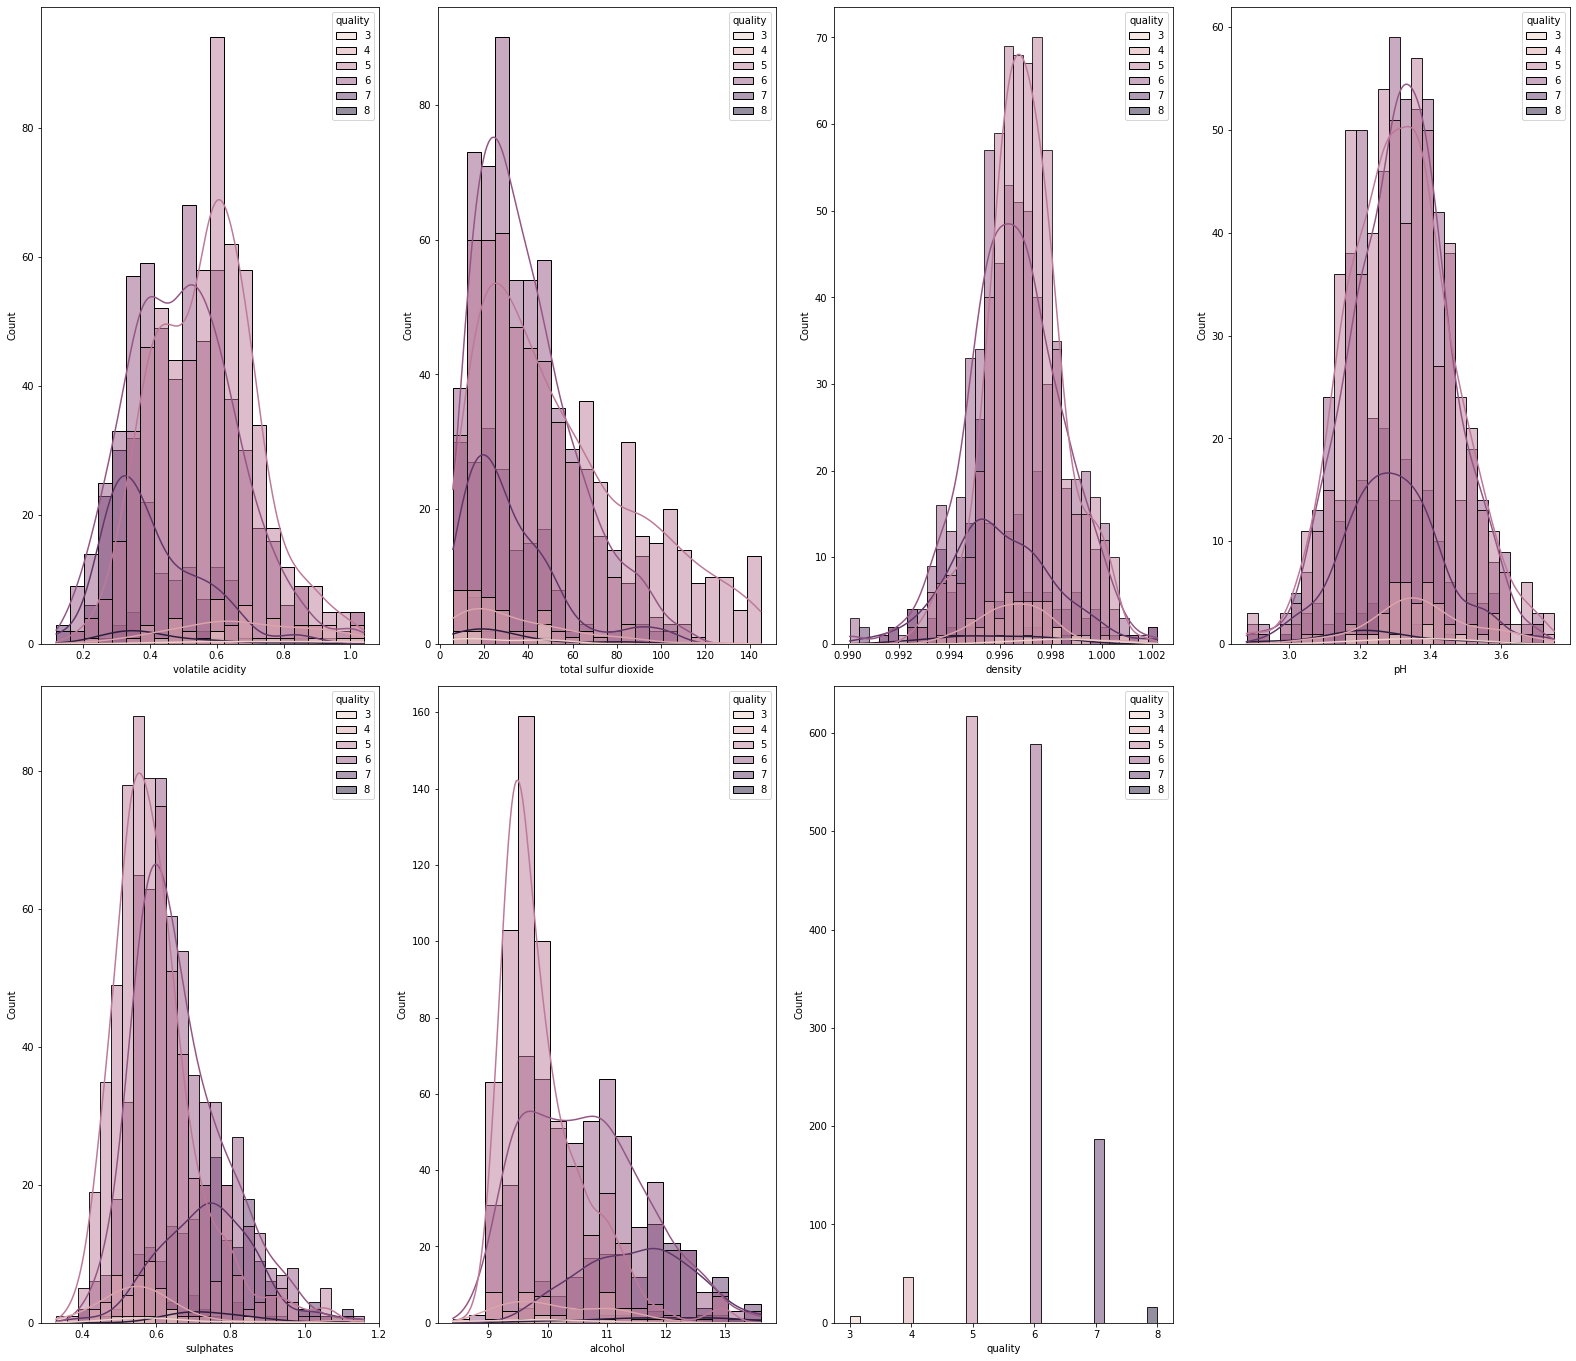

In [ ]:
#Data Distribution of all the columns 
fig = plt.figure(figsize=(22,28))
for i in range(len(final_data.columns)):
  fig.add_subplot(3,4,i+1)
  sns.histplot(x = final_data[final_data.columns[i]], hue = final_data.quality, kde = True)
  plt.xlabel(final_data.columns[i])
plt.tight_layout()
plt.show()

All the columns are almost normally distributed and have no outliers(total sulfer dioxide has left skewed data distribution)

In [ ]:
final_data['quality'] = np.where(final_data.quality>5, 'Good', 'Bad')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
final_data.quality.value_counts()

Good    792
Bad     671
Name: quality, dtype: int64

In [ ]:
#Labelencoding to the target values in 1 and 0 
Le = LabelEncoder()
final_data.quality = Le.fit_transform(final_data.quality)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Select feature and target
feature = final_data.drop(columns = ['quality']).values
target = final_data.quality.values
feature, target

(array([[ 0.7    , 34.     ,  0.9978 ,  3.51   ,  0.56   ,  9.4    ],
        [ 0.88   , 67.     ,  0.9968 ,  3.2    ,  0.68   ,  9.8    ],
        [ 0.76   , 54.     ,  0.997  ,  3.26   ,  0.65   ,  9.8    ],
        ...,
        [ 0.51   , 40.     ,  0.99574,  3.42   ,  0.75   , 11.     ],
        [ 0.645  , 44.     ,  0.99547,  3.57   ,  0.71   , 10.2    ],
        [ 0.31   , 42.     ,  0.99549,  3.39   ,  0.66   , 11.     ]]),
 array([0, 0, 0, ..., 1, 0, 1]))

In [ ]:
#Feature Scalling (I am using Standardization scalling) 
standard_scala = StandardScaler() # Use sklearn package call standard scala
feature = standard_scala.fit_transform(feature) 
feature

array([[ 1.04114828, -0.33348353,  0.62895043,  1.37154914, -0.62908566,
        -0.99743189],
       [ 2.10090897,  0.78358102,  0.05911771, -0.81572426,  0.2937275 ,
        -0.60813176],
       [ 1.39440184,  0.34352529,  0.17308426, -0.39238102,  0.06302421,
        -0.60813176],
       ...,
       [-0.07748801, -0.13038088, -0.54490498,  0.73653428,  0.83203517,
         0.55976861],
       [ 0.71733251,  0.00502088, -0.69875981,  1.79489238,  0.52443078,
        -0.21883164],
       [-1.25499989, -0.06268   , -0.68736316,  0.52486266,  0.1399253 ,
         0.55976861]])

In [ ]:
#train test split 
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=43)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1170, 6), (293, 6), (1170,), (293,))

In [ ]:
# To get more accuracy, convert the features from multi dimensions to the single dimension. 

pca = PCA(n_components = 1)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [ ]:
x_train.shape, x_test.shape

((1170, 1), (293, 1))

##Support Vector Regression

In [ ]:
#Initialize the SVR Model, with Linear kernel 
svr_regressor = SVR(kernel = 'linear')
#Fit the model with train dataset
svr_regressor.fit(x_train, y_train)
#Predict the test features using trained model 
y_pred = svr_regressor.predict(x_test)
y_pred = np.ndarray.round(y_pred)

In [ ]:
#SVR Metrics implementation
model_evaluation_svr = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'r_squared' : r2_score(y_test, y_pred),
    'RMSE': mean_squared_error(y_test, y_pred),
    'MAE' : mean_absolute_error(y_test, y_pred)
 
}
model_evaluation = pd.DataFrame.from_dict(model_evaluation_svr, orient='index' , columns=['Support Vector Regression'])
model_evaluation

,Support Vector Regression
Accuracy,0.723549
r_squared,-0.123722
RMSE,0.276451
MAE,0.276451


 ## Logist Regression

In [ ]:
#Initialize Logistic Regression Model
L_regressor = LogisticRegression()
#Fit the model with train dataset
L_regressor.fit(x_train, y_train)
#Predict the test features using trained model 
y_pred = L_regressor.predict(x_test)
y_pred = np.ndarray.round(y_pred)

In [ ]:
model_evaluation['Logistic Regression'] = [accuracy_score(y_test, y_pred), r2_score(y_test, y_pred),mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)]

####Comparing the two regression models results

In [ ]:
model_evaluation

,Support Vector Regression,Logistic Regression
Accuracy,0.723549,0.716724
r_squared,-0.123722,-0.151468
RMSE,0.276451,0.283276
MAE,0.276451,0.283276


####Feature Importance

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=300)
rf_classifier.fit(feature, target)
feature_importance = rf_classifier.feature_importances_

In [ ]:
px.bar(x = final_data.columns[:-1].values, y = feature_importance, 
       labels = {
           'x': 'Columns Name',
           'y':'Column Importance'
           }, 
       title = 'Column\'s importance based on Random Forest Classifier',
       color_discrete_sequence =px.colors.qualitative.Antique)